# Preserving spatial derivatives with safeguards

In this example, which has been adpted from the ZFP evaluation at <https://computing.llnl.gov/projects/zfp/zfp-and-derivatives>, we compare how three different lossy compressors (ZFP, SZ3, and SPERR) affect the Laplacian of the data, and apply safeguards to guarantee that the Laplacian is preserved. We also briefly investigate the impact of tuning the error bound for a lossy error-bounded compressor to optimize the compression ratio after applying safeguards.

QPET supports mean error bounds over non-overlapping blocks of data, but not over overlapping windows of data, which are required to preserve an error over a finite-difference approximated spatial derivative. To be safe, QPET would need to be configured with a maximally conservative pointwise error bound, which is no different than configuring SPERR (or SZ3 or ZFP) with this error bound. Therefore, we do not compare with QPET in this example.

In [1]:
import humanize
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
x = y = np.linspace(-1, 1, 1024)
Y, X = np.meshgrid(y, x, indexing="ij")

In [3]:
dx = float(x[1] - x[0])
dy = float(y[1] - y[0])
dy, dx

(0.0019550342130987275, 0.0019550342130987275)

In [4]:
def compute_corrections_percentage(my_U: np.ndarray, orig_U: np.ndarray) -> float:
    return np.mean(my_U != orig_U)

In [5]:
# plot the Laplacian DU for a 2D field my_U
def plot_DU(
    compute_DU,
    my_U,
    cr,
    ax,
    title,
    DU_eb_abs,
    transform_symbol=None,
    my_DU=None,
    corr=None,
    my_U_it=None,
    cr_it=None,
    include_boundary=False,
):
    show_err = my_DU is None

    if my_DU is None:
        my_DU = compute_DU(my_U)

    DU = compute_DU(U)

    vmin = np.nanmin(DU)
    vmax = np.nanmax(DU)

    err_U_inf = np.amax(np.abs(my_U - U))
    err_DU_inf = np.amax(np.abs(my_DU - DU))
    err_DU_fin_inf = np.nanmax(
        np.nan_to_num(
            np.abs(my_DU - DU),
            nan=np.nan,
            posinf=np.nan,
            neginf=np.nan,
        )
    )
    err_DU_2 = np.sqrt(np.mean(np.square(my_DU - DU)))
    err_DU_fin_2 = np.sqrt(
        np.nanmean(
            np.nan_to_num(
                np.square(my_DU - DU),
                nan=np.nan,
                posinf=np.nan,
                neginf=np.nan,
            )
        )
    )
    err_v = np.mean(~(np.abs(my_DU - DU) <= DU_eb_abs))

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    if show_err:
        if my_U_it is not None:
            corr_it = (
                None if corr is None else compute_corrections_percentage(my_U_it, corr)
            )

        corr = None if corr is None else compute_corrections_percentage(my_U, corr)

        transform_start = "" if transform_symbol is None else f"{transform_symbol}("
        transform_end = "" if transform_symbol is None else ")"

        ax.set_title(
            f"{title}\n"
            + rf"$L_{{\infty}}(\hat{{u}})$={err_U_inf:.02}  "
            + rf"$L_{{\infty}}({transform_start}\Delta \hat{{u}}{transform_end})$={err_DU_inf:.02}"
            + ("" if np.isfinite(err_DU_inf) else f" ({err_DU_fin_inf:.02})")
            + "\n"
            + rf"$L_{{2}}({transform_start}\Delta \hat{{u}}{transform_end})$={err_DU_2:.02}"
            + ("" if np.isfinite(err_DU_2) else f" ({err_DU_fin_2:.02})")
            + "\n"
            + f"V={0 if err_v == 0 else np.format_float_positional(100 * err_v, precision=1, min_digits=1) + '%'}"
            + (
                ""
                if corr is None
                else (
                    f"  C={0 if corr == 0 else np.format_float_positional(100 * corr, precision=1, min_digits=1) + '%'}"
                    + (
                        ""
                        if corr_it is None
                        else (
                            f" ({0 if corr == 0 else np.format_float_positional(100 * corr_it, precision=1, min_digits=1) + '%'})"
                        )
                    )
                )
            )
        )
    else:
        ax.set_title(f"{title}\n\n")

    # create a colourmap that includes the entire finite range of my_DU but
    #  assigns colours based on the range of DU to ensure consistent colours
    cx = np.linspace(
        (
            np.minimum(np.amin(np.nan_to_num(my_DU, nan=0, posinf=0, neginf=0)), vmin)
            - vmin
        )
        / (vmax - vmin),
        (
            np.maximum(vmax, np.amax(np.nan_to_num(my_DU, nan=0, posinf=0, neginf=0)))
            - vmin
        )
        / (vmax - vmin),
        256,
    )
    cmap = LinearSegmentedColormap.from_list("RdBu_r_ext", plt.get_cmap("RdBu_r")(cx))

    ax.fill_between(
        [0, 1],
        [1, 1],
        hatch="XX",
        edgecolor="magenta",
        facecolor="lavenderblush",
        transform=ax.transAxes,
        zorder=-13,
    )
    im = ax.imshow(my_DU, cmap=cmap, origin="lower", extent=(-1, 1, -1, 1), zorder=-12)

    ax.contour(
        X if include_boundary else X[1:-1, 1:-1],
        Y if include_boundary else Y[1:-1, 1:-1],
        my_DU,
        levels=10,
        colors="lightgrey",
        vmin=vmin,
        vmax=vmax,
        alpha=0.25,
        zorder=-11,
    )

    ax.set_rasterization_zorder(-10)
    ax.set_aspect("equal")

    t = ax.text(
        0.95,
        0.95,
        (
            f"x {np.round(cr, 2)}"
            + ("" if cr_it is None else f" (x {np.round(cr_it, 2)})")
        )
        if show_err
        else humanize.naturalsize(U.nbytes, binary=True),
        ha="right",
        va="top",
        transform=ax.transAxes,
    )
    t.set_bbox(dict(facecolor="white", alpha=0.5, edgecolor="black"))

    cb = ax.get_figure().colorbar(im, cax=cax, orientation="vertical")

    if show_err:
        cb.ax.fill_between(
            cb.ax.get_xlim(),
            cb.ax.get_ylim()[0],
            np.amin(DU),
            hatch="xxx",
            ec="w",
            fc="none",
        )
        cb.ax.fill_between(
            cb.ax.get_xlim(),
            np.amax(DU),
            cb.ax.get_ylim()[1],
            hatch="xxx",
            ec="w",
            fc="none",
        )

In [6]:
def table_DU(
    compute_DU,
    my_U,
    cr,
    title,
    codec_eb_abs,
    DU_eb_abs,
    corr,
    my_U_it,
    cr_it,
    title_corr=None,
    cr_corr=None,
) -> pd.DataFrame:
    cdc = title_corr is not None

    DU = compute_DU(U)
    my_DU = compute_DU(my_U)
    my_DU_it = compute_DU(my_U_it)
    my_DU_corr = compute_DU(corr)

    err_U_inf = np.amax(np.abs(my_U - U))
    err_DU_inf = np.amax(np.abs(my_DU - DU))
    err_DU_inf_fin = np.nanmax(
        np.nan_to_num(
            np.abs(my_DU - DU),
            nan=np.nan,
            posinf=np.nan,
            neginf=np.nan,
        )
    )
    err_DU_2 = np.sqrt(np.mean(np.square(my_DU - DU)))
    err_DU_2_fin = np.sqrt(
        np.nanmean(
            np.nan_to_num(
                np.square(my_DU - DU),
                nan=np.nan,
                posinf=np.nan,
                neginf=np.nan,
            )
        )
    )

    err_v = np.mean(~(np.abs(my_DU - DU) <= DU_eb_abs))
    err_v = (
        0
        if err_v == 0
        else np.format_float_positional(100 * err_v, precision=1, min_digits=1) + "%"
    )

    err_U_inf_it = np.amax(np.abs(my_U_it - U))
    err_DU_inf_it = np.amax(np.abs(my_DU_it - DU))
    err_DU_inf_fin_it = np.nanmax(
        np.nan_to_num(
            np.abs(my_DU_it - DU),
            nan=np.nan,
            posinf=np.nan,
            neginf=np.nan,
        )
    )
    err_DU_2_it = np.sqrt(np.mean(np.square(my_DU_it - DU)))
    err_DU_2_fin_it = np.sqrt(
        np.nanmean(
            np.nan_to_num(
                np.square(my_DU_it - DU),
                nan=np.nan,
                posinf=np.nan,
                neginf=np.nan,
            )
        )
    )

    err_v_it = np.mean(~(np.abs(my_DU_it - DU) <= DU_eb_abs))
    err_v_it = (
        0
        if err_v_it == 0
        else np.format_float_positional(100 * err_v_it, precision=1, min_digits=1) + "%"
    )

    if cdc:
        err_U_inf_corr = np.amax(np.abs(corr - U))
        err_DU_inf_corr = np.amax(np.abs(my_DU_corr - DU))
        err_DU_inf_fin_corr = np.nanmax(
            np.nan_to_num(
                np.abs(my_DU_corr - DU),
                nan=np.nan,
                posinf=np.nan,
                neginf=np.nan,
            )
        )
        err_DU_2_corr = np.sqrt(np.mean(np.square(my_DU_corr - DU)))
        err_DU_2_fin_corr = np.sqrt(
            np.nanmean(
                np.nan_to_num(
                    np.square(my_DU_corr - DU),
                    nan=np.nan,
                    posinf=np.nan,
                    neginf=np.nan,
                )
            )
        )

        err_v_corr = np.mean(~(np.abs(my_DU_corr - DU) <= DU_eb_abs))
        err_v_corr = (
            0
            if err_v_corr == 0
            else np.format_float_positional(100 * err_v_corr, precision=1, min_digits=1)
            + "%"
        )

    corr_it = compute_corrections_percentage(my_U_it, corr)
    corr = compute_corrections_percentage(my_U, corr)

    corr = (
        0
        if corr == 0
        else np.format_float_positional(100 * corr, precision=1, min_digits=1) + "%"
    )
    corr_it = (
        0
        if corr_it == 0
        else np.format_float_positional(100 * corr_it, precision=1, min_digits=1) + "%"
    )

    return pd.DataFrame(
        {
            "Compressor": ([title] if cdc else []) + [title, title],
            r"$\epsilon_{abs}$": ([codec_eb_abs] if cdc else [])
            + [codec_eb_abs, codec_eb_abs],
            "Safeguards": ([title_corr] if cdc else []) + ["one-shot", "iterative"],
            r"$L_{\infty}(\hat{u})$": ([f"{err_U_inf_corr:.02}"] if cdc else [])
            + [
                f"{err_U_inf:.02}",
                f"{err_U_inf_it:.02}",
            ],
            r"$L_{\infty}(\Delta \hat{u})$": (
                [
                    f"{err_DU_inf_corr:.02}"
                    + (
                        ""
                        if np.isfinite(err_DU_inf_corr)
                        else f" ({err_DU_inf_fin_corr:.02})"
                    )
                ]
                if cdc
                else []
            )
            + [
                f"{err_DU_inf:.02}"
                + ("" if np.isfinite(err_DU_inf) else f" ({err_DU_inf_fin:.02})"),
                f"{err_DU_inf_it:.02}"
                + ("" if np.isfinite(err_DU_inf_it) else f" ({err_DU_inf_fin_it:.02})"),
            ],
            r"$L_{2}(\Delta \hat{u})$": (
                [
                    f"{err_DU_2_corr:.02}"
                    + (
                        ""
                        if np.isfinite(err_DU_2_corr)
                        else f" ({err_DU_2_fin_corr:.02})"
                    )
                ]
                if cdc
                else []
            )
            + [
                f"{err_DU_2:.02}"
                + ("" if np.isfinite(err_DU_2) else f" ({err_DU_2_fin:.02})"),
                f"{err_DU_2_it:.02}"
                + ("" if np.isfinite(err_DU_2_it) else f" ({err_DU_2_fin_it:.02})"),
            ],
            "V": ([err_v_corr] if cdc else []) + [err_v, err_v_it],
            "C": ([""] if cdc else []) + [corr, corr_it],
            "CR": ([f"x {np.round(cr_corr, 2)}"] if cdc else [])
            + [
                f"x {np.round(cr, 2)}",
                f"x {np.round(cr_it, 2)}",
            ],
        }
    )

## Example 1: $u(x, y) = {(x^2 + y^2)}^{3 \mathbin{/} 2} \mathbin{/} 9$

The Laplacian of $u$ is $\Delta u = \sqrt{x^2 + y^2}$.

We evaluate the Laplacian numerically on the original $u$ and the compressed $\hat{u}$ by using the second-order central difference approximation.

In [7]:
U = np.power(X**2 + Y**2, 3 / 2) / 9

In [8]:
# analytical Laplacian on uncompressed
DU = np.sqrt(X**2 + Y**2)

In [9]:
# absolute error bound on the Laplacian
DU_eb_abs = 0.1

In [10]:
from compression_safeguards import SafeguardKind
from compression_safeguards.utils.bindings import Bindings

# we use a constant grid spacing and the valid boundary condition to preserve
#  an absolute error bound over the Laplacian, but not on the data boundaries
#  where data points do not have a left, right, upper, and lower neighbour
qoi_eb_stencil = SafeguardKind.qoi_eb_stencil.value(
    qoi="""
    (
        finite_difference(x, order=2, accuracy=2, type=0, axis=0, grid_spacing=c["dy"]) +
        finite_difference(x, order=2, accuracy=2, type=0, axis=1, grid_spacing=c["dx"])
    )
    """,
    neighbourhood=[
        dict(axis=0, before=1, after=1, boundary="valid"),
        dict(axis=1, before=1, after=1, boundary="valid"),
    ],
    type="abs",
    eb=DU_eb_abs,
)


# evaluate the Laplacian numerically by evaluating the quantity of interest
def compute_DU(U):
    return qoi_eb_stencil.evaluate_qoi(U, late_bound=Bindings(dx=dx, dy=dy))

### Compressing u with lossy compressors

We configure each compressor with an absolute error bound of $7 \cdot 10^{-7}$ over the `u` array. For each compressor, we also test two more error bounds to investigate the impact of tuning: one that produces around 1% of violations for the absolute error bound over the Laplacian, and one that produces no violations.

In [11]:
# absolute error bound for error-bounded lossy compression
eb_abs = 7e-7

In [12]:
# we test several error bounds to showcase the impact of tuning
# - eb_abs: common error bound
# - tuned to get ~1% violations
# - tuned to get 0 violations
eb_abs_zfps = [eb_abs, 9e-7, 2e-7]

In [13]:
# compressed with ZFP
from numcodecs_wasm_zfp import Zfp

zfp = dict()
U_zfp = dict()
U_zfp_cr = dict()

for eb_abs_zfp in eb_abs_zfps:
    zfp[eb_abs_zfp] = Zfp(mode="fixed-accuracy", tolerance=eb_abs_zfp)

    U_zfp_enc = zfp[eb_abs_zfp].encode(U)
    U_zfp[eb_abs_zfp] = zfp[eb_abs_zfp].decode(U_zfp_enc)
    U_zfp_cr[eb_abs_zfp] = U.nbytes / U_zfp_enc.nbytes

In [14]:
eb_abs_sz3s = [eb_abs, 2.5e-6, 6e-8]

In [15]:
# compressed with SZ3
from numcodecs_wasm_sz3 import Sz3

sz3 = dict()
U_sz3 = dict()
U_sz3_cr = dict()

for eb_abs_sz3 in eb_abs_sz3s:
    sz3[eb_abs_sz3] = Sz3(eb_mode="abs", eb_abs=eb_abs_sz3)

    U_sz3_enc = sz3[eb_abs_sz3].encode(U)
    U_sz3[eb_abs_sz3] = sz3[eb_abs_sz3].decode(U_sz3_enc)
    U_sz3_cr[eb_abs_sz3] = U.nbytes / U_sz3_enc.nbytes

In [16]:
eb_abs_sperrs = [eb_abs, 4e-7, 8e-8]

In [17]:
# compressed with SPERR
from numcodecs_wasm_sperr import Sperr

sperr = dict()
U_sperr = dict()
U_sperr_cr = dict()

for eb_abs_sperr in eb_abs_sperrs:
    sperr[eb_abs_sperr] = Sperr(mode="pwe", pwe=eb_abs_sperr)

    U_sperr_enc = sperr[eb_abs_sperr].encode(U)
    U_sperr[eb_abs_sperr] = sperr[eb_abs_sperr].decode(U_sperr_enc)
    U_sperr_cr[eb_abs_sperr] = U.nbytes / U_sperr_enc.nbytes

In [18]:
# compressed to constant zero
from numcodecs_zero import ZeroCodec

zero = ZeroCodec()

U_zero_enc = zero.encode(U)
U_zero = zero.decode(U_zero_enc)

### Compressing u using the safeguards-wrapped lossy compressors

We configure the safeguards to bound the pointwise absolute error on the derived Laplacian.

For this first example, we only evaluate the Laplacian numerically on non-boundary points, allowing us to only use second-order central finite differences.

In [19]:
from numcodecs_safeguards import SafeguardsCodec

U_sg_qoi = dict()
U_sg_qoi_cr = dict()

# compressed with the safeguards with an absolute error bound over the Laplacian
for codecs in [zfp, sz3, sperr, {0: zero}]:
    U_sg_qoi_codec = dict()
    U_sg_qoi_codec_cr = dict()

    for eb_abs_codec, codec in codecs.items():
        codec_sg_qoi = SafeguardsCodec(
            codec=codec,
            safeguards=[qoi_eb_stencil],
            fixed_constants=dict(dx=dx, dy=dy),
        )

        U_sg_qoi_enc = codec_sg_qoi.encode(U)
        U_sg_qoi_codec[eb_abs_codec] = codec_sg_qoi.decode(U_sg_qoi_enc)
        U_sg_qoi_codec_cr[eb_abs_codec] = U.nbytes / np.asarray(U_sg_qoi_enc).nbytes

    U_sg_qoi[codec.codec_id] = U_sg_qoi_codec
    U_sg_qoi_cr[codec.codec_id] = U_sg_qoi_codec_cr

In [20]:
U_sg_it_qoi = dict()
U_sg_it_qoi_cr = dict()

# compressed with the safeguards with an absolute error bound over the Laplacian
for codecs in [zfp, sz3, sperr, {0: zero}]:
    U_sg_it_qoi_codec = dict()
    U_sg_it_qoi_codec_cr = dict()

    for eb_abs_codec, codec in codecs.items():
        codec_sg_it_qoi = SafeguardsCodec(
            codec=codec,
            safeguards=[qoi_eb_stencil],
            fixed_constants=dict(dx=dx, dy=dy),
            # use iteration to refine the corrections
            compute=dict(unstable_iterative=True),
        )

        U_sg_it_qoi_enc = codec_sg_it_qoi.encode(U)
        U_sg_it_qoi_codec[eb_abs_codec] = codec_sg_it_qoi.decode(U_sg_it_qoi_enc)
        U_sg_it_qoi_codec_cr[eb_abs_codec] = (
            U.nbytes / np.asarray(U_sg_it_qoi_enc).nbytes
        )

    U_sg_it_qoi[codec.codec_id] = U_sg_it_qoi_codec
    U_sg_it_qoi_cr[codec.codec_id] = U_sg_it_qoi_codec_cr

### Visual comparison of the compressed Laplacians

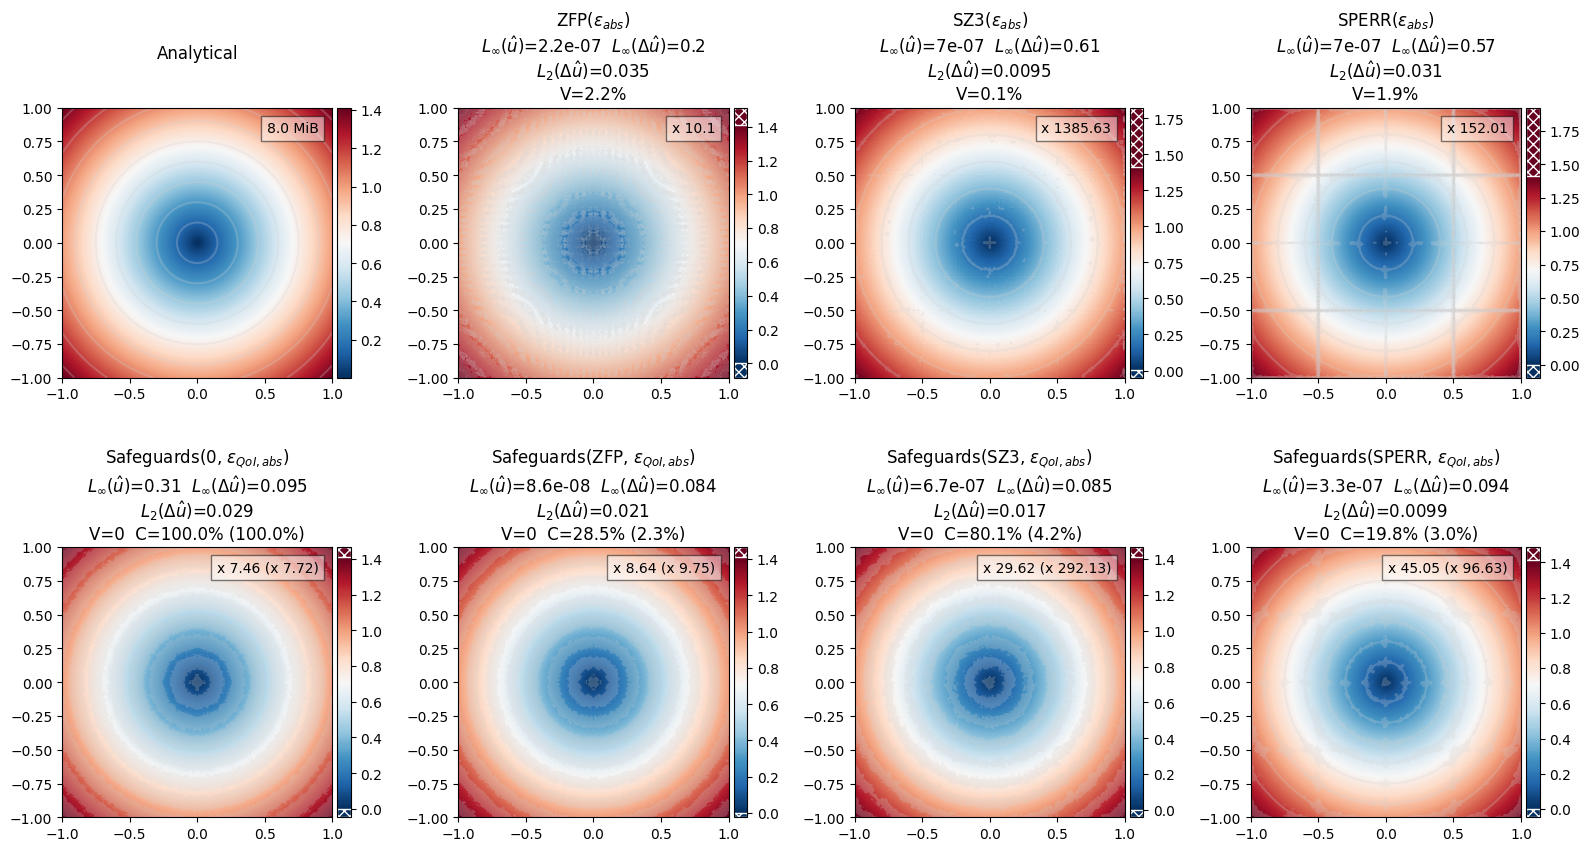

In [21]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16, 9))

plot_DU(
    compute_DU,
    U,
    1.0,
    axs[0, 0],
    "Analytical",
    DU_eb_abs=DU_eb_abs,
    my_DU=DU[1:-1, 1:-1],
)
plot_DU(
    compute_DU,
    U_zfp[eb_abs],
    U_zfp_cr[eb_abs],
    axs[0, 1],
    r"ZFP($\epsilon_{abs}$)",
    DU_eb_abs=DU_eb_abs,
)
plot_DU(
    compute_DU,
    U_sz3[eb_abs],
    U_sz3_cr[eb_abs],
    axs[0, 2],
    r"SZ3($\epsilon_{abs}$)",
    DU_eb_abs=DU_eb_abs,
)
plot_DU(
    compute_DU,
    U_sperr[eb_abs],
    U_sperr_cr[eb_abs],
    axs[0, 3],
    r"SPERR($\epsilon_{abs}$)",
    DU_eb_abs=DU_eb_abs,
)

plot_DU(
    compute_DU,
    U_sg_qoi["zero"][0],
    U_sg_qoi_cr["zero"][0],
    axs[1, 0],
    r"Safeguards(0, $\epsilon_{QoI,abs}$)",
    DU_eb_abs=DU_eb_abs,
    corr=U_zero,
    my_U_it=U_sg_it_qoi["zero"][0],
    cr_it=U_sg_it_qoi_cr["zero"][0],
)
plot_DU(
    compute_DU,
    U_sg_qoi["zfp.rs"][eb_abs],
    U_sg_qoi_cr["zfp.rs"][eb_abs],
    axs[1, 1],
    r"Safeguards(ZFP, $\epsilon_{QoI,abs}$)",
    DU_eb_abs=DU_eb_abs,
    corr=U_zfp[eb_abs],
    my_U_it=U_sg_it_qoi["zfp.rs"][eb_abs],
    cr_it=U_sg_it_qoi_cr["zfp.rs"][eb_abs],
)
plot_DU(
    compute_DU,
    U_sg_qoi["sz3.rs"][eb_abs],
    U_sg_qoi_cr["sz3.rs"][eb_abs],
    axs[1, 2],
    r"Safeguards(SZ3, $\epsilon_{QoI,abs}$)",
    DU_eb_abs=DU_eb_abs,
    corr=U_sz3[eb_abs],
    my_U_it=U_sg_it_qoi["sz3.rs"][eb_abs],
    cr_it=U_sg_it_qoi_cr["sz3.rs"][eb_abs],
)
plot_DU(
    compute_DU,
    U_sg_qoi["sperr.rs"][eb_abs],
    U_sg_qoi_cr["sperr.rs"][eb_abs],
    axs[1, 3],
    r"Safeguards(SPERR, $\epsilon_{QoI,abs}$)",
    DU_eb_abs=DU_eb_abs,
    corr=U_sperr[eb_abs],
    my_U_it=U_sg_it_qoi["sperr.rs"][eb_abs],
    cr_it=U_sg_it_qoi_cr["sperr.rs"][eb_abs],
)

plt.tight_layout()

plt.savefig("derivative-radial.pdf", dpi=300)

plt.show()

In [22]:
u_radial_sg_table = pd.concat(
    [
        table_DU(
            compute_DU,
            U_sg_qoi["zero"][0],
            U_sg_qoi_cr["zero"][0],
            r"Safeguards(0, $\epsilon_{QoI,abs}$)",
            "",
            DU_eb_abs,
            U_zero,
            U_sg_it_qoi["zero"][0],
            U_sg_it_qoi_cr["zero"][0],
        )
    ]
    + [
        table_DU(
            compute_DU,
            U_sg_qoi["zfp.rs"][eb_abs_zfp],
            U_sg_qoi_cr["zfp.rs"][eb_abs_zfp],
            r"Safeguards(ZFP, $\epsilon_{QoI,abs}$)",
            f"{eb_abs_zfp}",
            DU_eb_abs,
            U_zfp[eb_abs_zfp],
            U_sg_it_qoi["zfp.rs"][eb_abs_zfp],
            U_sg_it_qoi_cr["zfp.rs"][eb_abs_zfp],
            title_corr="ZFP",
            cr_corr=U_zfp_cr[eb_abs_zfp],
        )
        for eb_abs_zfp in eb_abs_zfps
    ]
    + [
        table_DU(
            compute_DU,
            U_sg_qoi["sz3.rs"][eb_abs_sz3],
            U_sg_qoi_cr["sz3.rs"][eb_abs_sz3],
            r"Safeguards(SZ3, $\epsilon_{QoI,abs}$)",
            f"{eb_abs_sz3}",
            DU_eb_abs,
            U_sz3[eb_abs_sz3],
            U_sg_it_qoi["sz3.rs"][eb_abs_sz3],
            U_sg_it_qoi_cr["sz3.rs"][eb_abs_sz3],
            title_corr="SZ3",
            cr_corr=U_sz3_cr[eb_abs_sz3],
        )
        for eb_abs_sz3 in eb_abs_sz3s
    ]
    + [
        table_DU(
            compute_DU,
            U_sg_qoi["sperr.rs"][eb_abs_sperr],
            U_sg_qoi_cr["sperr.rs"][eb_abs_sperr],
            r"Safeguards(SPERR, $\epsilon_{QoI,abs}$)",
            f"{eb_abs_sperr}",
            DU_eb_abs,
            U_sperr[eb_abs_sperr],
            U_sg_it_qoi["sperr.rs"][eb_abs_sperr],
            U_sg_it_qoi_cr["sperr.rs"][eb_abs_sperr],
            title_corr="SPERR",
            cr_corr=U_sperr_cr[eb_abs_sperr],
        )
        for eb_abs_sperr in eb_abs_sperrs
    ]
).set_index(["Compressor", r"$\epsilon_{abs}$", "Safeguards"])

u_radial_sg_table.to_latex("derivative-radial.tex", escape=True)

u_radial_sg_table

$L_{\infty}(\hat{u})$  \
Compressor                              $\epsilon_{abs}$ Safeguards                         
Safeguards(0, $\epsilon_{QoI,abs}$)                      one-shot                    0.31   
                                                         iterative                   0.31   
Safeguards(ZFP, $\epsilon_{QoI,abs}$)   7e-07            ZFP                      2.2e-07   
                                                         one-shot                 8.6e-08   
                                                         iterative                1.7e-07   
                                        9e-07            ZFP                      2.2e-07   
                                                         one-shot                 8.6e-08   
                                                         iterative                1.7e-07   
                                        2e-07            ZFP                      5.2e-08   
                                                         one-shot                 5.2e-08   
                                                         iterative                5.2e-08   
Safeguards(SZ3, $\epsilon_{QoI,abs}$)   7e-07            SZ3                        7e-07   
                                                         one-shot                 6.7e-07   
                                                         iterative                6.9e-07   
                                        2.5e-06          SZ3                      2.5e-06   
                                                         one-shot                 2.3e-06   
                                                         iterative                2.3e-06   
                                        6e-08            SZ3                        6e-08   
                                                         one-shot                   6e-08   
                                                         iterative                  6e-08   
Safeguards(SPERR, $\epsilon_{QoI,abs}$) 7e-07            SPERR                      7e-07   
                                                         one-shot                 3.3e-07   
                                                         iterative                5.4e-07   
                                        4e-07            SPERR                      4e-07   
                                                         one-shot                 3.4e-07   
                                                         iterative                3.6e-07   
                                        8e-08            SPERR                      8e-08   
                                                         one-shot                   8e-08   
                                                         iterative                  8e-08   

                                                                    $L_{\infty}(\Delta \hat{u})$  \
Compressor                              $\epsilon_{abs}$ Safeguards                                
Safeguards(0, $\epsilon_{QoI,abs}$)                      one-shot                          0.095   
                                                         iterative                         0.095   
Safeguards(ZFP, $\epsilon_{QoI,abs}$)   7e-07            ZFP                                 0.2   
                                                         one-shot                          0.084   
                                                         iterative                           0.1   
                                        9e-07            ZFP                                 0.2   
                                                         one-shot                          0.084   
                                                         iterative                           0.1   
                                        2e-07            ZFP                               0.052   
                                                         one-shot                   

## Example 2: $u(x, y) = e^{4 x + 3 y}$

The Laplacian of $u$ is $\Delta u = 25 u$.

We plot the natural logarithm of the Laplacian.

In [23]:
U = np.exp(4 * X + 3 * Y)

In [24]:
# analytical solution on uncompressed
DU = U * 25

In [25]:
# absolute error bound on the natural logarithm of the Laplacian
ln_DU_eb_abs = 1.0

In [26]:
# we use the safeguard's support for arbitrary grid-based spacing and switch
#  from 2nd order central finite differences to 2nd order forward/backwards
#  finite differences at the data boundaries, where data points do not have a
#  left, right, upper, and lower neighbour
# this enables us to compute the Laplacian at all data points, including at
#  the boundaries
# we pad the data with NaNs to denote the missing values
qoi_eb_stencil = SafeguardKind.qoi_eb_stencil.value(
    qoi="""
    V["d2Udy"] = where(
        c["Y"] > -1,
        where(
            c["Y"] < 1,
            # use 2nd order central finite difference where possible
            finite_difference(
                x, order=2, accuracy=2, type=0, axis=0, grid_centre=c["Y"]
            ),
            # use 2nd order backwards finite difference at the upper boundary
            finite_difference(
                x, order=2, accuracy=1, type=-1, axis=0, grid_centre=c["Y"]
            ),
        ),
        # use 2nd order forward finite difference at the lower boundary
        finite_difference(
            x, order=2, accuracy=1, type=1, axis=0, grid_centre=c["Y"]
        ),
    );

    V["d2Udx"] = where(
        c["X"] > -1,
        where(
            c["X"] < 1,
            # use 2nd order central finite difference where possible
            finite_difference(
                x, order=2, accuracy=2, type=0, axis=1, grid_centre=c["X"]
            ),
            # use 2nd order backwards finite difference at the right boundary
            finite_difference(
                x, order=2, accuracy=1, type=-1, axis=1, grid_centre=c["X"]
            ),
        ),
        # use 2nd order forward finite difference at the left boundary
        finite_difference(
            x, order=2, accuracy=1, type=1, axis=1, grid_centre=c["X"]
        ),
    );

    # compute the natural logarithm of the Laplacian
    return ln(V["d2Udy"] + V["d2Udx"]);
    """,
    neighbourhood=[
        dict(axis=0, before=2, after=2, boundary="constant", constant_boundary=np.nan),
        dict(axis=1, before=2, after=2, boundary="constant", constant_boundary=np.nan),
    ],
    type="abs",
    eb=DU_eb_abs,
)


# evaluate the Laplacian numerically by evaluating the quantity of interest
def compute_ln_DU(U):
    return qoi_eb_stencil.evaluate_qoi(U, late_bound=Bindings(X=X, Y=Y))

### Compressing u with lossy compressors

We configure each compressor with an absolute error bound of $10^{-3}$ over the `u` array.

In [27]:
# absolute error bound for error-bounded lossy compression
eb_abs = 1e-3

In [28]:
# compressed with ZFP
from numcodecs_wasm_zfp import Zfp

zfp = Zfp(mode="fixed-accuracy", tolerance=eb_abs)

U_zfp_enc = zfp.encode(U)
U_zfp = zfp.decode(U_zfp_enc)
U_zfp_cr = U.nbytes / U_zfp_enc.nbytes

In [29]:
# compressed with SZ3
from numcodecs_wasm_sz3 import Sz3

sz3 = Sz3(eb_mode="abs", eb_abs=eb_abs)

U_sz3_enc = sz3.encode(U)
U_sz3 = sz3.decode(U_sz3_enc)
U_sz3_cr = U.nbytes / U_sz3_enc.nbytes

In [30]:
# compressed with SPERR
from numcodecs_wasm_sperr import Sperr

sperr = Sperr(mode="pwe", pwe=eb_abs)

U_sperr_enc = sperr.encode(U)
U_sperr = sperr.decode(U_sperr_enc)
U_sperr_cr = U.nbytes / U_sperr_enc.nbytes

In [31]:
# compressed to constant zero
from numcodecs_zero import ZeroCodec

zero = ZeroCodec()

U_zero_enc = zero.encode(U)
U_zero = zero.decode(U_zero_enc)

### Compressing u using the safeguards-wrapped lossy compressors

We configure the safeguards to bound the pointwise absolute error on the derived natural logarithm of the Laplacian.

For this second example, we use second-order central finite differences on non-boundary points and second-order forward/backwards finite differences on boundary points so that we can evaluate the Laplacian everywhere.

In [32]:
U_sg_qoi = dict()
U_sg_qoi_cr = dict()

# compressed with the safeguards with an absolute error bound over the log of the Laplacian
for codec in [zfp, sz3, sperr, zero]:
    codec_sg_qoi = SafeguardsCodec(
        codec=codec,
        safeguards=[qoi_eb_stencil],
        fixed_constants=dict(X=X, Y=Y),
    )

    U_sg_qoi_enc = codec_sg_qoi.encode(U)
    U_sg_qoi[codec.codec_id] = codec_sg_qoi.decode(U_sg_qoi_enc)
    U_sg_qoi_cr[codec.codec_id] = U.nbytes / np.asarray(U_sg_qoi_enc).nbytes

In [33]:
U_sg_it_qoi = dict()
U_sg_it_qoi_cr = dict()

# compressed with the safeguards with an absolute error bound over the log of the Laplacian
for codec in [zfp, sz3, sperr, zero]:
    codec_sg_it_qoi = SafeguardsCodec(
        codec=codec,
        safeguards=[qoi_eb_stencil],
        fixed_constants=dict(X=X, Y=Y),
        # use iteration to refine the corrections
        compute=dict(unstable_iterative=True),
    )

    U_sg_it_qoi_enc = codec_sg_it_qoi.encode(U)
    U_sg_it_qoi[codec.codec_id] = codec_sg_it_qoi.decode(U_sg_it_qoi_enc)
    U_sg_it_qoi_cr[codec.codec_id] = U.nbytes / np.asarray(U_sg_it_qoi_enc).nbytes

### Visual comparison of the compressed natural logarithms of the Laplacians

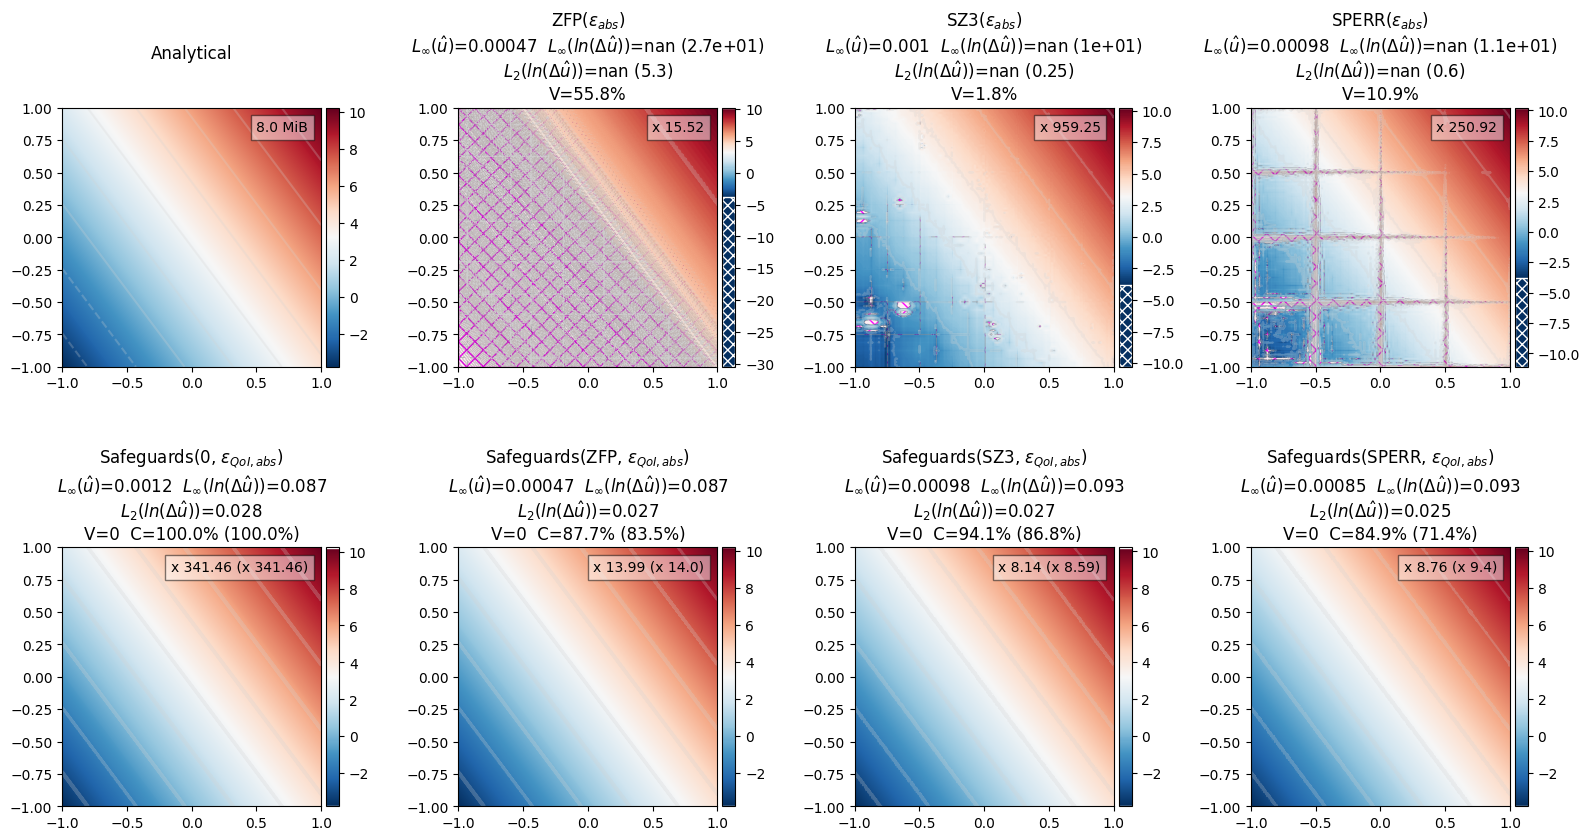

In [34]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16, 9))

plot_DU(
    compute_ln_DU,
    U,
    1.0,
    axs[0, 0],
    "Analytical",
    DU_eb_abs=ln_DU_eb_abs,
    my_DU=np.log(DU),
    transform_symbol="ln",
    include_boundary=True,
)
plot_DU(
    compute_ln_DU,
    U_zfp,
    U_zfp_cr,
    axs[0, 1],
    r"ZFP($\epsilon_{abs}$)",
    DU_eb_abs=ln_DU_eb_abs,
    transform_symbol="ln",
    include_boundary=True,
)
plot_DU(
    compute_ln_DU,
    U_sz3,
    U_sz3_cr,
    axs[0, 2],
    r"SZ3($\epsilon_{abs}$)",
    DU_eb_abs=ln_DU_eb_abs,
    transform_symbol="ln",
    include_boundary=True,
)
plot_DU(
    compute_ln_DU,
    U_sperr,
    U_sperr_cr,
    axs[0, 3],
    r"SPERR($\epsilon_{abs}$)",
    DU_eb_abs=ln_DU_eb_abs,
    transform_symbol="ln",
    include_boundary=True,
)

plot_DU(
    compute_ln_DU,
    U_sg_qoi["zero"],
    U_sg_qoi_cr["zero"],
    axs[1, 0],
    r"Safeguards(0, $\epsilon_{QoI,abs}$)",
    DU_eb_abs=ln_DU_eb_abs,
    transform_symbol="ln",
    corr=U_zero,
    my_U_it=U_sg_it_qoi["zero"],
    cr_it=U_sg_it_qoi_cr["zero"],
    include_boundary=True,
)
plot_DU(
    compute_ln_DU,
    U_sg_qoi["zfp.rs"],
    U_sg_qoi_cr["zfp.rs"],
    axs[1, 1],
    r"Safeguards(ZFP, $\epsilon_{QoI,abs}$)",
    DU_eb_abs=ln_DU_eb_abs,
    transform_symbol="ln",
    corr=U_zfp,
    my_U_it=U_sg_it_qoi["zfp.rs"],
    cr_it=U_sg_it_qoi_cr["zfp.rs"],
    include_boundary=True,
)
plot_DU(
    compute_ln_DU,
    U_sg_qoi["sz3.rs"],
    U_sg_qoi_cr["sz3.rs"],
    axs[1, 2],
    r"Safeguards(SZ3, $\epsilon_{QoI,abs}$)",
    DU_eb_abs=ln_DU_eb_abs,
    transform_symbol="ln",
    corr=U_sz3,
    my_U_it=U_sg_it_qoi["sz3.rs"],
    cr_it=U_sg_it_qoi_cr["sz3.rs"],
    include_boundary=True,
)
plot_DU(
    compute_ln_DU,
    U_sg_qoi["sperr.rs"],
    U_sg_qoi_cr["sperr.rs"],
    axs[1, 3],
    r"Safeguards(SPERR, $\epsilon_{QoI,abs}$)",
    DU_eb_abs=ln_DU_eb_abs,
    transform_symbol="ln",
    corr=U_sperr,
    my_U_it=U_sg_it_qoi["sperr.rs"],
    cr_it=U_sg_it_qoi_cr["sperr.rs"],
    include_boundary=True,
)

plt.tight_layout()

plt.savefig("derivative-log-exp.pdf", dpi=300)

plt.show()

In [35]:
u_log_exp_sg_table = (
    pd.concat(
        [
            table_DU(
                compute_ln_DU,
                U_sg_qoi["zero"],
                U_sg_qoi_cr["zero"],
                r"Safeguards(0, $\epsilon_{QoI,abs}$)",
                "",
                ln_DU_eb_abs,
                U_zero,
                U_sg_it_qoi["zero"],
                U_sg_it_qoi_cr["zero"],
            ),
            table_DU(
                compute_ln_DU,
                U_sg_qoi["zfp.rs"],
                U_sg_qoi_cr["zfp.rs"],
                r"Safeguards(ZFP, $\epsilon_{QoI,abs}$)",
                f"{eb_abs}",
                ln_DU_eb_abs,
                U_zfp,
                U_sg_it_qoi["zfp.rs"],
                U_sg_it_qoi_cr["zfp.rs"],
                title_corr="ZFP",
                cr_corr=U_zfp_cr,
            ),
            table_DU(
                compute_ln_DU,
                U_sg_qoi["sz3.rs"],
                U_sg_qoi_cr["sz3.rs"],
                r"Safeguards(SZ3, $\epsilon_{QoI,abs}$)",
                f"{eb_abs}",
                ln_DU_eb_abs,
                U_sz3,
                U_sg_it_qoi["sz3.rs"],
                U_sg_it_qoi_cr["sz3.rs"],
                title_corr="SZ3",
                cr_corr=U_sz3_cr,
            ),
            table_DU(
                compute_ln_DU,
                U_sg_qoi["sperr.rs"],
                U_sg_qoi_cr["sperr.rs"],
                r"Safeguards(SPERR, $\epsilon_{QoI,abs}$)",
                f"{eb_abs}",
                ln_DU_eb_abs,
                U_sperr,
                U_sg_it_qoi["sperr.rs"],
                U_sg_it_qoi_cr["sperr.rs"],
                title_corr="SPERR",
                cr_corr=U_sperr_cr,
            ),
        ]
    )
    .drop(r"$\epsilon_{abs}$", axis="columns")
    .set_index(["Compressor", "Safeguards"])
)

u_log_exp_sg_table.to_latex("derivative-log-exp.tex", escape=True)

u_log_exp_sg_table

$L_{\infty}(\hat{u})$  \
Compressor                              Safeguards                         
Safeguards(0, $\epsilon_{QoI,abs}$)     one-shot                  0.0012   
                                        iterative                 0.0012   
Safeguards(ZFP, $\epsilon_{QoI,abs}$)   ZFP                      0.00047   
                                        one-shot                 0.00047   
                                        iterative                0.00047   
Safeguards(SZ3, $\epsilon_{QoI,abs}$)   SZ3                        0.001   
                                        one-shot                 0.00098   
                                        iterative                0.00099   
Safeguards(SPERR, $\epsilon_{QoI,abs}$) SPERR                    0.00098   
                                        one-shot                 0.00085   
                                        iterative                0.00092   

                                                   $L_{\infty}(\Delta \hat{u})$  \
Compressor                              Safeguards                                
Safeguards(0, $\epsilon_{QoI,abs}$)     one-shot                          0.087   
                                        iterative                         0.087   
Safeguards(ZFP, $\epsilon_{QoI,abs}$)   ZFP                       nan (2.7e+01)   
                                        one-shot                          0.087   
                                        iterative                           0.1   
Safeguards(SZ3, $\epsilon_{QoI,abs}$)   SZ3                         nan (1e+01)   
                                        one-shot                          0.093   
                                        iterative                           0.1   
Safeguards(SPERR, $\epsilon_{QoI,abs}$) SPERR                     nan (1.1e+01)   
                                        one-shot                          0.093   
                                        iterative                           0.1   

                                                   $L_{2}(\Delta \hat{u})$  \
Compressor                              Safeguards                           
Safeguards(0, $\epsilon_{QoI,abs}$)     one-shot                     0.028   
                                        iterative                    0.028   
Safeguards(ZFP, $\epsilon_{QoI,abs}$)   ZFP                      nan (5.3)   
                                        one-shot                     0.027   
                                        iterative                    0.029   
Safeguards(SZ3, $\epsilon_{QoI,abs}$)   SZ3                     nan (0.25)   
                                        one-shot                     0.027   
                                        iterative                    0.027   
Safeguards(SPERR, $\epsilon_{QoI,abs}$) SPERR                    nan (0.6)   
                                        one-shot                     0.025   
                                        iterative                    0.025   

                                                        V       C        CR  
Compressor                              Safeguards                           
Safeguards(0, $\epsilon_{QoI,abs}$)     one-shot        0  100.0%  x 341.46  
                                        iterative       0  100.0%  x 341.46  
Safeguards(ZFP, $\epsilon_{QoI,abs}$)   ZFP         55.8%           x 15.52  
                                        one-shot        0   87.7%   x 13.99  
                                        iterative       0   83.5%    x 14.0  
Safeguards(SZ3, $\epsilon_{QoI,abs}$)   SZ3          1.8%          x 959.25  
                                        one-shot        0   94.1%    x 8.14  
                                        iterative       0   86.8%    x 8.59  
Safeguards(SPERR, $\epsilon_{QoI,abs}$) SPERR       10.9%          x 250.92  
                                        one-shot        0   84.9%    x 8.76  
                               